In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import scvelo as scv

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.data import DataLoader
from RnaVeloDataset import RnaVeloDataset
from model.BaseModel import BaseModelClassification

In [3]:
dataset = RnaVeloDataset(root='data/')
len(dataset)

75

In [22]:
t = np.arange(13)
train_mask = list(t) + list(t + 15) + list(t + 30) + list(t + 45) + list(t + 60)
val_mask = [13, 14, 28, 29, 43, 44, 58, 59, 73, 74]

In [4]:
train_mask = [0]
val_mask = [0]

In [25]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        scores = model(data)
        scores = scores.sum(axis=0)
        label = data.y.to(device)
        loss = F.cross_entropy(scores.reshape(1, -1), label)
        loss.backward()
        total_loss += data.num_graphs * loss.item()
        optimizer.step()

    return float(total_loss / len(train_loader.dataset))

def test(loader):
    model.eval()
    
    correct = 0
    predict = 0
    for data in loader:
        data = data.to(device)
        label = data.y.detach().cpu().numpy()
        scores = model(data).detach().cpu().numpy()
        scores = softmax(np.sum(scores, axis=0))
        if np.argmax(scores) == label[0]:
            correct += 1
        predict += 1
    return correct / predict


In [28]:
dataset = RnaVeloDataset(root='data/')
batch_size = 1
train_loader = DataLoader(dataset[train_mask], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset[val_mask], batch_size=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = BaseModelClassification(dataset.num_features, 5).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=0.01)

best_val_perf = test_perf = 0

train_list = []
val_list = []
train_loss_list = []
for epoch in range(251):
    train_loss = train()
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)
    train_loss_list.append(train_loss)

Epoch: 000, Loss: 29.9595, Train: 0.1385, Val: 0.0000
Epoch: 010, Loss: 1.5428, Train: 0.2154, Val: 0.1000
Epoch: 020, Loss: 1.3316, Train: 0.4615, Val: 0.3000
Epoch: 030, Loss: 1.0588, Train: 0.6615, Val: 0.4000
Epoch: 040, Loss: 0.8897, Train: 0.7538, Val: 0.5000
Epoch: 050, Loss: 0.7361, Train: 0.8462, Val: 0.6000
Epoch: 060, Loss: 0.5692, Train: 0.8923, Val: 0.6000
Epoch: 070, Loss: 0.5967, Train: 0.8769, Val: 0.6000
Epoch: 080, Loss: 0.4737, Train: 0.9231, Val: 0.7000
Epoch: 090, Loss: 0.4239, Train: 0.9231, Val: 0.6000
Epoch: 100, Loss: 0.3527, Train: 0.8462, Val: 0.6000
Epoch: 110, Loss: 0.2935, Train: 0.9231, Val: 0.6000
Epoch: 120, Loss: 0.2853, Train: 0.9538, Val: 0.6000
Epoch: 130, Loss: 0.2140, Train: 0.9692, Val: 0.6000
Epoch: 140, Loss: 0.2267, Train: 0.9538, Val: 0.6000
Epoch: 150, Loss: 0.1746, Train: 0.9846, Val: 0.7000
Epoch: 160, Loss: 0.1240, Train: 0.9846, Val: 0.7000
Epoch: 170, Loss: 0.1359, Train: 1.0000, Val: 0.7000
Epoch: 180, Loss: 0.1709, Train: 1.0000, Val:

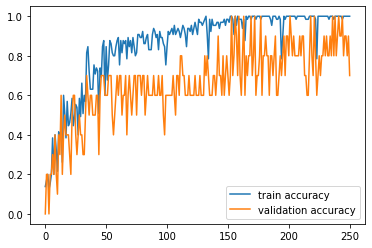

In [29]:
plt.plot(train_list)
plt.plot(val_list)
plt.legend(['train accuracy', 'validation accuracy'], loc='uppder right')
plt.show()

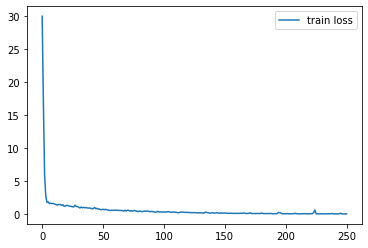

In [30]:
plt.plot(train_loss_list)
plt.legend(['train loss'], loc='uppder right')
plt.show()